In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import os
import tarfile
import pylab as plt

In [3]:
import  pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')

In [4]:
Path = 'excel/housing.csv'

In [5]:
dataset = pd.read_csv(Path)    

In [6]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
#housing['population']

In [10]:
dataset.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

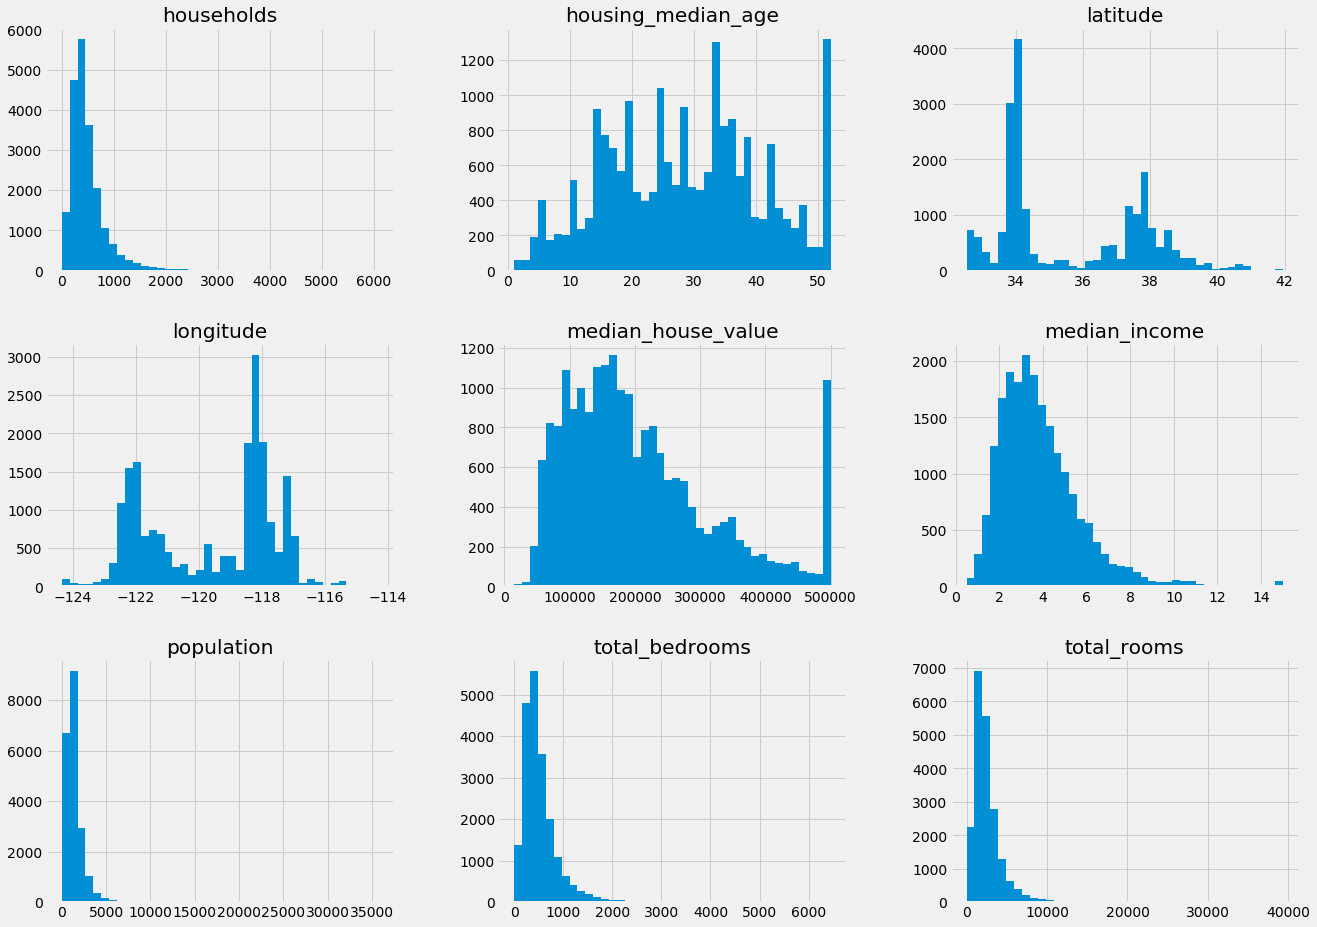

In [11]:
dataset.hist(bins=40, figsize=(20,15))
plt.show()

### Spliting the data

Creating a test set where we just pick some instances randomly typically 20% of the datatset, and set them aside.

In [12]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(dataset, 0.2)
print('Whole:',len(dataset),' = Train:',len(train_set),' + Test:',len(test_set))

Whole: 20640  = Train: 16512  + Test: 4128


While this is  good approach to splitting data, it is vunerable to reading in biases as everytime algorithm see the test set it becomes bias something we should avoid in the first place. Its basically going to break everytime you update the dataset as the data that was in the test set will end up in the trainning set once we update tshe data

The other approach available is to try and use the index/identifier column to build  

In [14]:
import hashlib

In [15]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [16]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [17]:
dataset_with_id = dataset.reset_index()
train_set, test_set = split_train_test_by_id(dataset_with_id, 0.2 ,"index")

In [18]:
dataset_with_id['id'] = dataset['longitude']*1000+dataset['latitude']
train_set, test_set = split_train_test_by_id(dataset_with_id, 0.2, 'id')

In [19]:
dataset_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [20]:
from sklearn.model_selection import train_test_split
sk_train, sk_test_set = train_test_split(dataset, test_size=0.2, random_state=42)

In [21]:
dataset['income_cat']= np.ceil(dataset['median_income']/1.5)
dataset['income_cat'].where(dataset['income_cat'] < 5, 5.0, inplace=True)

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index, in split.split(dataset, dataset['income_cat']):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [23]:
dataset['income_cat'].value_counts()/len(dataset)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [24]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

In [25]:
housing = strat_train_set.copy()

In [26]:
housing2= strat_train_set.copy()

In [27]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## Visualising the data to gain insights

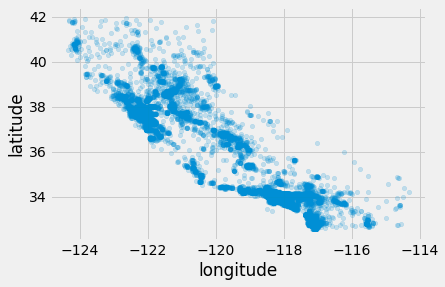

In [28]:
housing.plot(kind= 'scatter', x='longitude', y='latitude', alpha=.2)

ploting house prices the radius is the district population, and the color represents the price. cmap is predefined we choose jet 

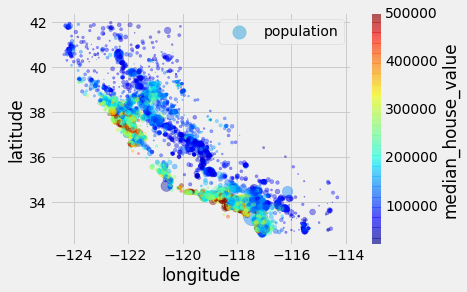

In [29]:
housing.plot(kind='scatter', x= 'longitude', y= 'latitude', alpha=0.4,
            s=housing['population']/100, label='population', c='median_house_value',
           cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

This image gives us the intuitive answer that the population density and location  drive the prices of the houses. But more analysis is required to confirm this because in some places it might not holdd true. 

### Looking for correlations


In [30]:
corr_matrix = housing.corr()

In [31]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [32]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


Lets use pandas scatter matrix to get some visuals on these correlations 

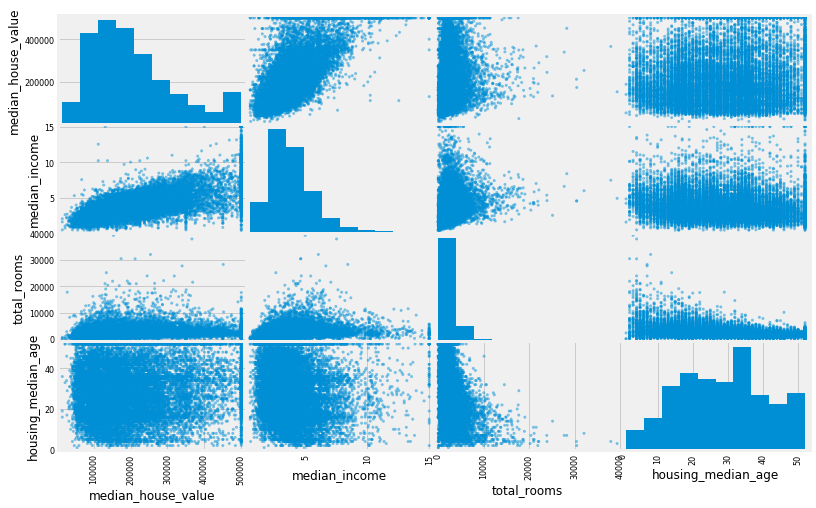

In [33]:
%matplotlib inline
from pandas.plotting import scatter_matrix

attribute = [ 'median_house_value', 'median_income',
             'total_rooms', 'housing_median_age']
scatter_matrix(housing[attribute], figsize=(12,8))
plt.show()

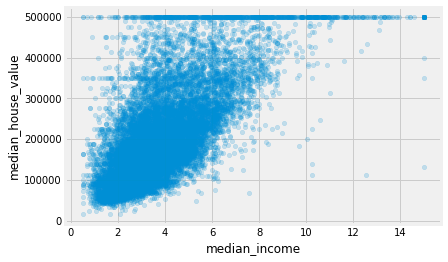

In [34]:

housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.2)

This plot shows that the correlation betwen the two attributes is indeed very strong but we also get to see some insights that we might have not focused on earlier e.g. The apparent caps _@_ 450000 and another one around 280000. We can try to remove some of the correspoding districts to limit the effects of the quirks on the model. 

#### Experimenting with Attribute Combinations

Trying out various attribute combinations. For example, the total number of rooms in the district is not very useful if you don't know how many households there are. 

In [35]:
housing['rooms_per_households'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [36]:
corr_matrix = housing.corr()

In [37]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_households        0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [38]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

#### Data Cleaning

When it comes to data cleaning we start wth dealing with missing values 

In [39]:
#housing.dropna(subset=['total_bedrooms']) option 1
#housing.drop('total_bedrooms', axis=1) option 2
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Le

Sklearn provides a way to deal with missing values: its called the Imputer
The Imputer simply deals with all the missing values for all attributes by replacing them with a value of your choice. The computed values from the Imputer can be accessed by calling the Imputer.statics_.

In [40]:
try:
    from sklearn.impute import SimpleImputer
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
imputer = SimpleImputer(strategy='median')

In [41]:
housing_num = housing.drop('ocean_proximity',axis=1)

In [42]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [43]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [44]:
X = imputer.transform(housing_num)

In [45]:
housing_tr = pd.DataFrame(X, columns= housing_num.columns)

#### Handling Text and Categorical Attributes 

One way to deal with Text attributes is to convert them into numerical values. For this dataset we have one attribute with text data, we shall use it as an example to show how we would go about converting data  

In [46]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
housing_cat = housing[['ocean_proximity']]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [47]:
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values, which is not the case. So to fix it we create a one binary category per category for example  '_INLAND_' is equal to one and everything else is equal to zero, also when '_ISLAND_' is equal to one and everything is equal to zero

In [48]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [49]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Another way to deal with text attribtes using Sklearn is to use LabelBinarizer this class does the above steps in one go.

In [50]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer() # option sparse_out=True
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

Writing a custom Transformer is important because all problems come with different challenges  

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix,  population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ('total_rooms', 'total_bedrooms','population','households')]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room  = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:,household_ix]
        population_per_household = X[:, population_ix]/X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

In [52]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room= False)
housing_extra_attribs = attr_adder.transform(housing.values)

Another way to create the transformer is through the Transformer class based on the transformation function.

In [53]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix]  / X[:, household_xi]
    population_per_room = X[:, population_ix] / X[:, household_xi]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_hosuehold, population_per_household]

    attr_adder = FunctionTransformer(add_extra_features, validate=False, 
                                    kw_args={"add_bedrooms_room":False})
    housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [54]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [55]:
tyt =['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
 'rooms_per_household','population_per_house', 'bedrooms_per_room']

In [56]:

housing_fr = pd.DataFrame(housing_extra_attribs, columns= tyt)

In [58]:
housing_fr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_house,bedrooms_per_room
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [59]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


### Feature Scaling 

When dealing with data with wild scales, we need to normalize the data in order to get the attribute at the same scale.
Min_Max Scaling: Is when values are shifted and rescaled so that they endup ranging from 0 to 1. It is done by subtracting the min Value and dividing by the max minus the min.

Standardization: With this method we subtract the mean value to get the mean to zero, we then divide the mean by the variance so that the resulting distribution has a unit variance.

### Transformation Pipelines

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [74]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [75]:
#transforming the categorical data and numerical data 
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [76]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Selecting and Training a Model 

In [79]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [80]:
#Testing the model on a  sample of instances 
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
somedata_prepared = full_pipeline.transform(some_data)

print('Predictions: ', lin_reg.predict(somedata_prepared))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Comparing the predctions with the actual values

In [81]:
print('Label:', list(some_labels))

Label: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [84]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [89]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001898

In [92]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [93]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Oh wow according to the decision tree, we neednt do anything any more because our mode is perfect which is not the case, the more likely scenario is that we're over fitting on our data, we can use a validation set check how well out model is doing

# Fine-Tuneing the model

In [95]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_score = np.sqrt(-scores)

```python
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attibs =['ocean_proximity']

num_pipeline  = ([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cate_attribs)),
    ('label_binarizer', LabelBinarizer()),
])
full_pipeline =FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])
```

In [63]:
#from sklearn.compose import ColumnTransformer

#num_attribs =h

3+3

In [64]:
3+3

6